# Building Machine Learning Models

In the [previous notebook](https://github.com/YaleDHLab/lab-workshops/blob/master/machine-learning/machine-learning.ipynb), we used machine learning to classify, cluster, and analyze data. We talked about the algorithms we used to accomplish these tasks, but we did not write our own algorithms for conducting machine learning. In this notebook, we'll explore machine learning from a lower-level in order to understand the mechanics behind some of the simplest machine learning algorithms.

Our goal in this notebook will be to use machine learning to create a model that can accurately predict the price of a home given that home's square footage. Pursuing this goal will allow us to get some exposure to the low-level mechanics behind numerical optimization, which drives much of contemporary machine learning. Let's dive in!

## Predicting House Prices with Linear Regression

Suppose we have some data that identifies the square footage and cost of a number for several houses. We'll generate and visualize this data just as we did before:

Text(0, 0.5, 'House Price (in thousands)')

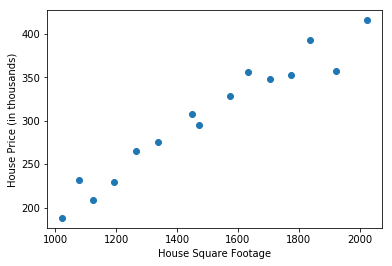

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
np.random.seed(13)

# identify the number of houses to include in the dataset
n_observations = 15

# generate a price and square footage value for each house
prices = np.linspace(200, 400, num=n_observations)
footage = np.linspace(1000, 2000, num=n_observations)

# introduce some "noise" into the data so footage and price are not perfectly linearly related
prices = prices + np.random.randint(-30, 30, size=(n_observations,))
footage = footage + np.random.randint(-30, 30, size=(n_observations,))

# plot the housing data we just generated
plt.scatter(footage, prices)
plt.xlabel('House Square Footage')
plt.ylabel('House Price (in thousands)')

Now suppose someone asked you: *How much do you expect a house with 1,400 square feet to cost?*

Looking at the data above, you can see that there's a rough "linear" relationship between house size and price&mdash;as house square footage goes up, house price goes up proportionally. Given that trend, you might imagine a line of best fit running from the lower-left to the upper-right regions of the chart (the red line below). After drawing that line, you might try to find the point where the 1,400 square foot value meets that line. We can identify that point as a red dot below:

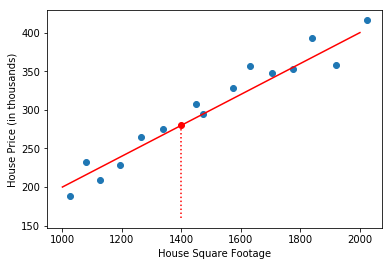

In [2]:
plt.scatter(footage, prices)
plt.xlabel('House Square Footage')
plt.ylabel('House Price (in thousands)')
plt.plot([1400], [280], marker='o', color='red') # plot the estimated house price as a point
plt.plot([1400, 1400], [160, 280], c='red', linestyle=':') # draw the inference lines as a dotted line
plt.plot([1000, 2000], [200, 400], c='red', linestyle='-') # draw the line of best fit as a solid line

So we could estimate that a house with 1,400 square feet would cost roughly $280,000.

This operation we have just performed&mdash;inferring the value of some variable at some position given some scatterplot-style data&mdash;is the general task of a [**linear regression model**](https://en.wikipedia.org/wiki/Linear_regression). "Linear regression" is just a fancy term for the process of fitting a curve (such as a straight line) to some data, where fitting a curve means finding some line of best fit that follows the general trajectory of the data nicely. In the example above, we fit the red line to our price and square footage data.

Now suppose a classmate or colleague gave you a list with the square footage of 1000 different New Haven houses, and asked you to estimate the price of each. Rather than look up the prices on the line of best fit manually, you might try to find an *equation* for the line of best fit, as an equation would let you plug in each square footage value to get a good price estimate. As you may recall, a line (such as our line of best fit above) has the general equation:

\begin{align*}
y &= m \times x + b \\
\end{align*}

Here $m$ denotes the slope of the line, and $b$ denotes the y-intercept of the line. We can interpret the $y$ and $x$ values for our equation by setting $y$ (the value we wish to predict) to the price of a house, and by setting $x$ (the data we're given) to the square footage of a house. This gives us:

\begin{align*}
\textit{house price} &= m \times \textit{square footage} + b \\
\end{align*}

Now **all we need to do is find values for $m$ (the slope) and $b$ (the y intercept) that let us identify the line of best fit for our data** (i.e. the red line above). How should we do that?

## Estimating Linear Regression Parameters by Hand

As we've discussed, the $m$ term in the equation for a line refers to the line's slope. You might therefore try to determine $m$ by finding the "rise over the run", e.g. by choosing two points, then dividing the difference in their $y$ values by the difference in their $x$ values:

$$m = \frac{\Delta y}{\Delta x} \approx \frac{|y_i-y_j|}{|x_i-x_j|}$$

By using the first and last observations in the dataset as $i$ and $j$, we could estimate $m$ with the following:

In [3]:
m = abs(prices[0] - prices[-1]) / abs(footage[0] - footage[-1])

After estimating $m$, you could try to solve the equation $y = mx + b$ for $b$ by plugging a random data point's $x$ value (house square footage) and $y$ value (house price) into the equation:

In [4]:
# use the first data point to solve y = m*x+b for b
x = footage[0]
y = prices[0]

# rearrange the equation by subtracting m*x from both sides
b = y - (m * x)

Now that you have estimates for both $m$ and $b$, you could plot the resulting line of best fit estimate:

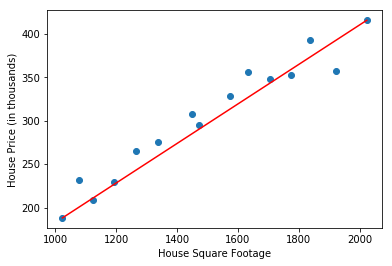

In [5]:
# Now we can plot the estimated function parameters:
def estimate_y(x):
  return m * x + b

x_vals = [footage[0], footage[-1]]
y_vals = [estimate_y(x_vals[0]), estimate_y(x_vals[1])]

plt.scatter(footage, prices)
plt.xlabel('House Square Footage')
plt.ylabel('House Price (in thousands)')
plt.plot(x_vals, y_vals, color='red')

That's not too bad! But is this trend line the best fit for the data we can find?

## Evaluating Linear Regression Parameters with a Loss Function

In order to improve our line of best fit, we need a way to measure the degree to which that line accurately models the trend in the underlying data points. To measure the fit of a linear model, we can use a [<b>loss function</b>](https://en.wikipedia.org/wiki/Loss_function). A loss function computes the accuracy of a model by measuring the difference between the values the model predicts and the corresponding "groundtruth" (or known data) values.

Many of the popular loss functions are variations on what is arguably the simplest loss function, the L1 Loss:

$$L1\ Loss = \sum_{i=1}^n |\ y_i-\hat{y}_i\ |$$

We can better understand this equation by defining the following:

\begin{align*}
\sum_{i=1}^n &= \textit{Sum over all values of i from 1 to n} \\
y_i &= \textit{the value the model should predict for the i-th data inputs} \\
\hat{y}_i &= \textit{the value the model did predict for the i-th data inputs} \\
|x| &= \textit{the absolute value of x }\\
\end{align*}

Putting this notation together, to compute the  L1 loss for a model, one must examine each input data point, find the difference between that data point's true $y$ value (in our case the actual house price) and the model's prediction $ŷ$ (in our case the predicted house price), take the absolute value of that difference, then sum those absolute differences.

The better the model fits the data (that is, the smaller the sum of the distances between $y$ and $ŷ$), the smaller the loss will be. We can see this in the following illustration. If you update the "offset" parameter and click "Run Model" again, you should see that as the line gets closer to the points, the aggregate loss decreases:

In [6]:
from IPython.display import IFrame
IFrame(src='https://s3.amazonaws.com/duhaime/blog/visualizations/l1-loss.html', width=1000, height=460)

Given the L1 loss function defined above, we can choose a range of values for both $m$ and $b$ and measure the loss associated with each pair of $m$ and $b$ values. Because the loss is a measure of how well the given linear model predicts house prices, the combination of $m$ and $b$ that produce the minimal loss value will be the best discovered model parameters. Let's generate a grid of $m$ and $b$ parameters and plot the loss associated with each:

In [7]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# generate losses for a parameter sweep over m, b params for visualizing the cost function for n observations
n = 100
m_vals = [-1 + i*.02 for i in range(n) ]
b_vals = [-50 + i for i in range(n)]

data = [] # will store m, b, loss
for m_val in m_vals:
  for b_val in b_vals:
    loss = np.sum( np.abs( (footage * m_val + b_val) - prices) ) # l1 loss
    data.append([m_val, b_val, loss])

# register for plotly account https://plot.ly/api_signup
plotly.tools.set_credentials_file(username='douglasduhaime', api_key='a4qYSyVRsspl2o39SzTk')

# plot the loss function
data = np.array(data)
layout = go.Layout(
  title='Linear Regression L1 Loss Curve',
  scene = dict(
    xaxis=dict(title='Slope (m)'),
    yaxis=dict(title='Intercept (b)'),
    zaxis=dict(title='Loss')
  )
)
surface = go.Surface(x=data[:,0].reshape(n, n), y=data[:,1].reshape(n, n), z=data[:,2].reshape(n, n))
fig = go.Figure(data=[surface], layout=layout)
py.iplot(fig, filename='surface-plot.png')

The plot above represents the L1 loss curve for our simple linear regression model. Each position along the "Slope" axis represents a different $m$ value (or slope for the line in the linear model), and each position along the "Intercept" axis represents a different $b$ value (or y-intercept for the line in the linear model). The "Loss" axis value for a combination of "Slope" and "Intercept" axis values indicates the loss associated with that combination of slope and intercept. As we can see, the loss tends to be minimized when the slope term $m$ is near 0.2. 

Given this grid of parameters and associated loss values, <b>we can identify the optimal model parameters by finding the parameter set that produces the minimal loss&mdash;i.e. the position along the Slope and Intercept axes where the Loss value is at a global minimum</b>.

In the case of the loss function plotted above, we might be able to just eyeball those values. With more complex functions, however, one can use a more sophisticated technique to find the minimum of the loss function curve. The most popular way to search for the minimum of the loss function is through **gradient descent**, to which we now turn.

## Identifying Optimal Model Parameters with Gradient Descent

In the cells above, we noted that a loss function measures the degree to which a model's predictions depart from the observed data. The smaller the loss, the better the model describes the data. We plotted the loss function for our simple linear model case, and recognized that the best model parameters are those for which the associated loss is minimal.

A popular way to find parameters that minimize a loss function is through the use of **gradient descent**. Stated simply, gradient descent is an iterative algorithm that identifies the slope of a curve (or function) at a series of points, in order to figure out how to adjust model parameters to find some minimum along that curve.

To understand the mechanics behind gradient descent, let's identify a simple function and plot its shape:

$$y = x^2$$

Text(0, 0.5, 'y vals')

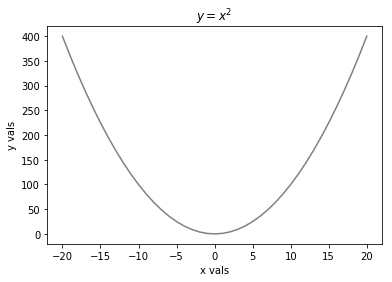

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

x_vals = list(range(-20, 21, 1))
y_vals = [x**2 for x in x_vals]

plt.plot(x_vals, y_vals, c='gray')
plt.title(r'$y = x^2$')
plt.xlabel('x vals')
plt.ylabel('y vals')

Using gradient descent is a way of identifying the position along the $y = x^2$ curve where the function finds a minimum. To find this point, one initializes the gradient descent algorithm by choosing a random position on the curve. We can think of this random position as being determined by the random parameters with which a model is initialized.

Given that random position along the curve, our goal will be to determine the slope of the curve with respect to each variable on the right hand of the equation. Those slope values tell us the degree to which the function changes when each of those variables changes. We can then use those slope values to move "downhill", e.g. towards a minimum in the curve.

In order to identify the slope of the curve with respect to each variable on the right hand of the equation, we can use the [derivative rules](https://en.wikipedia.org/wiki/Differentiation_rules) to calculate the first derivative of our curve with respect to each variable:

\begin{align*}
f(x) &= x^2 \\
\frac{\delta f}{\delta x} &= 2x
\end{align*}

The first equation above is just our equation for which we wish to find the minimum. The second equation is often pronounced "df, dx", which indicates the derivative of $f$ with respect to $x$. Once we know the derivative of the function with respect to $x$, we can start the gradient descent process by choosing an arbitrary value of $x$ (say 5) and running the main gradient descent algorithm:

#### Gradient Descent Algorithm

First we pass the current value of $x$ through the derivative we just identified ($2x = 2 \times 5 = 10$). We then multiply this product by a special value almost always referred to as <b>alpha</b>. This alpha value refers to the <b>learning rate</b> in the model, because smaller alpha values cause a model to learn more slowly but more surely while larger alpha values cause a model to learn more quickly and less reliably. Alpha values should generally be a quite small decimal value, often < 0.01. Let's use 0.01 as our alpha value. After multiplying the previous product by this alpha value ($10 \times 0.01 = 0.1$), we subtract the resulting product from the current value of $x$. This new value of $x$ should be closer to the minimum of the $f(x) = x^2$ function.

* * *

What we've just described is a full iteration of gradient descent. To continue moving $x$ closer to the minimum of the $f(x) = x^2$ curve, we'll continue running iterations of the algorithm described above until either we hit a user-defined maximum number of iterations or the difference between the old and new $x$ values falls below some very small threshold, which can indicate the gradient descent algorithm has "[converged](https://www.britannica.com/science/convergence-mathematics)". The value of $x$ that results from this process denotes the the value identified by gradient descent as the minimum of the function.

The following diagram [[source](https://bl.ocks.org/duhaime/afbb5535c07b1eed68febe31740359b5)] gives a visual demonstration of the way the current value of $x$ changes as we continue running gradient descent iterations. Each new value of $x$ will be represented by a new dot. As one can see, as long as the alpha is fairly small, each step gets closer to the minimum of the function:

In [9]:
from IPython.display import IFrame

IFrame(src='https://s3.amazonaws.com/duhaime/blog/visualizations/one-variable-gradient-descent.html', width=500, height=570)

## Using Gradient Descent to Optimize our House Price Model

Now that we've explored the basics of gradient descent, let's return to our Linear Regression house price problem and use gradient descent to find the optimal parameters for our linear model. To do so, we'll use the L2 loss function, which is quite similar to the L1 loss function we examined above, only the L2 loss squares the errors for each observation rather than taking the absolute value as the L1 loss does:

$$L1\ Loss = \sum_{i=1}^n |\ \hat{y}_i-y_i\ |$$
$$L2\ Loss = \sum_{i=1}^n (\ \hat{y}_i-y_i\ )^2$$

In fact, to simplify the math a little bit, we'll use a slight modification of the L2 loss. While the L2 loss, or [<b>Sum of Squared Error Loss</b>](https://en.wikipedia.org/wiki/Residual_sum_of_squares) (SSE) sums the squared errors for each input observation, we'll compute the Half-Mean Sum of Squared Error, which is just the $\frac{1}{2n} \times SSE$:

$$\textit{Half-Mean SSE Loss} = \frac{1}{2n} \sum_{i=1}^n (\ \hat{y}_i-y_i\ )^2 $$

where:

$$ \hat{y} = m \times x_i + b $$

As we noted above, $\hat{y}$ is just a shorthand for the value predicted by our function for a line. If we substitute in the function that generates $\hat{y}$, we get the full loss function $L$:

$$\textit{Half-Mean SSE Loss(m, b)} = \frac{1}{2n} \sum_{i=1}^n (\ m \times x_i + b - y_i\ )^2 \tag{1}$$

To find the derivative of this loss function with respect to $m$ and $b$ (the two parameters with which we define our line), we can break this loss function into two pieces:

$$\textit{L(m, b)} = \frac{1}{2n} \sum_{i=1}^n (f(m, b)^{(i)})^2\tag{2}$$

$$f(m, b)^{(i)} = m \times x_i + b - y_i\tag{3}$$

Here the $i$ superscript indicates that the given loss term is computed for the $ith$ set of inputs (the $ith$ $x$ and $y$ values in the training data).

If you substitute (3) into (2), you should see this composes the full loss function (1). Now all we need to do is differentiate (1) and (2) with respect to $m$ and $b$ and we'll be ready to run gradient descent.

### Finding the gradient with respect to $b$

Let's start by computing the slope (or derivative) of (2) with respect to $b$.

\begin{align*}
\frac{\delta}{\delta{b}} L(m, b) &= \frac{\delta}{\delta{b}} \frac{1}{2n} \sum_{i=1}^n (f(m, b)^{(i)} )^2 \tag{3} \\
&= 2 \times \frac{1}{2n} \sum_{i=1}^n f(m, b)^{(i)} \tag{exponent rule} \\
&= \frac{1}{n} \sum_{i=1}^n f(m, b)^{(i)} \tag{simplify}
\end{align*}

Given these equations we can compute the derivative of (3) with respect to $b$:

\begin{align*}
\frac{\delta}{\delta{b}} f(m, b)^{(i)} &= \frac{\delta}{\delta{b}} m \times x_i + b - y_i\tag{4} \\
\end{align*}

Since we are computing the derivative with respect to $b$, we can treat all terms that don't contain an $b$ as constants. Since the derivative of a constant is zero, we get:

\begin{align*}
\frac{\delta}{\delta{b}} f(m, b)^{(i)} &= \frac{\delta}{\delta{b}} m \times x_i + b - y_i \\
&= \frac{\delta}{\delta{b}} 0 + b - 0\tag{simplify} \\
&= \frac{\delta}{\delta{b}} b \tag{simplify} \\
&= 1 \tag{simplify} \\
\end{align*}

Using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), we can combine (3) and (4):

\begin{align*}
\frac{\delta}{\delta{b}}L(f(m, b)^{(i)}) &= \frac{\delta}{\delta{b}} L(m, b) \frac{\delta}{\delta{b}} f(m, b)^{(i)} \tag{5}
\end{align*}

Substituting in the partial derivatives with respect to $b$ we computed above in (3) and (4), we can compute the full partial derivative of $L$ with respect to $b$:

\begin{align*}
\frac{1}{n} \sum_{i=1}^{n} f(m, b)^{(i)} \times 1 \tag{6} \\
\frac{1}{n} \sum_{i=1}^{n} (m \times x_i + b - y_i) \times 1 \tag{simplify} \\
\frac{1}{n} \sum_{i=1}^{n} m \times x_i + b - y_i \tag{simplify} \\
\end{align*}

There we have it! The final equation above represents the partial derivative of our loss function with respect to $b$. Let's now compute the partial derivative of our loss function with respect to $m$.

### Finding the gradient with respect to $m$

The partial derivative of the outer function $L$ with respect to $m$ is the same as the partial derivative of $L$ with respect to $b$:

$$ \frac{\delta}{\delta{m}} L(m, b) = \frac{1}{n} \sum_{i=1}^n f(m, b)^{(i)} \tag{from 3} $$

Let's compute the derivative of $f$ with respect to $m$:

\begin{align*}
\frac{\delta}{\delta{m}} f(m, b)^{(i)} &= \frac{\delta}{\delta{m}} m \times x_i + b - y_i \tag{7} \\
\end{align*}

Just as before, we can treat all terms that don't contain the variable with respect to which we're differentiating the function as constants, for which the partial derivative will be 0:

\begin{align*}
\frac{\delta}{\delta{m}} f(m, b)^{(i)} &= \frac{\delta}{\delta{m}} m \times x_i + b - y_i \\
&= \frac{\delta}{\delta{m}} m \times x_i + 0 - 0\tag{simplify} \\
&= \frac{\delta}{\delta{m}} m \times x_i \tag{simplify} \\
&= x_i \tag{simplify} \\
\end{align*}

Using the chain rule, we can identify the full derivative of $L$ with respect to $m$:

\begin{align*}
\frac{\delta}{\delta{m}} L(f(m, b)) &= \frac{\delta}{\delta{m}} L(m, b) \frac{\delta}{\delta{m}} f(m, b) \tag{8} \\
&= \frac{1}{n} \sum_{i=1}^n f(m, b)^{(i)} \frac{\delta}{\delta{m}} f(m, b)^{(i)} \\
&= \frac{1}{n} \sum_{i=1}^n (m \times x_i + b - y_i) \times x_i
\end{align*}

---

Phew! We've finally computed the partial derivatives of our linear function with respect to our two model parameters $m$ and $b$:

$$ \frac{\delta{L}}{\delta{b}} = \frac{1}{n} \sum_{i=1}^{n} m \times x_i + b - y_i $$
$$ \frac{\delta{L}}{\delta{m}} = \frac{1}{n} \sum_{i=1}^n (m \times x_i + b - y_i) \times x_i $$

As we've noted, these partial derivatives let us determine the slope of the loss function with respect to the given variable ($m$ or $b$) at a given point along the loss curve. Now all we need to do is choose starting parameters for $m$ and $b$ and run the gradient descent algorithm described above. In the case of our linear model, we have two parameters we need to fit ($m$ and $b$), so we can run gradient descent to optimize those parameters with the following block:

In [10]:
from random import random

# initialize random parameters for model parameters
m = random()
b = random()

# set an alpha value or learning rate
alpha = 0.0000001

def iterate(m, b):
  '''Compute dL/db and dL/dm then update the estimates for m and b'''
  errs = []
  for idx, x in enumerate(footage):
    actual = prices[idx]
    predicted = (m * x) + b
    errs.append(predicted - actual)
  
  # compute dL/db
  dLdb = sum(errs) / len(errs)
  
  # compute dL/dm
  m_errs = [errs[idx] * footage[idx] for idx, _ in enumerate(footage)]
  dLdm = sum(m_errs) / len(m_errs)
  
  # update the model parameters given the loss values  
  b -= (dLdb * alpha)
  m -= (dLdm * alpha)

  # return the model parameters and the absolute value of the loss terms
  return m, b, abs(dLdb), abs(dLdm)

# iterate while the error terms remain above some threshold
m, b, dLdb, dLdm = iterate(m, b)
threshold = 0.5
while dLdb > threshold or dLdm > threshold:
  m, b, dLdb, dLdm = iterate(m, b)
  
# identify the resulting model params
print('resulting params -- m:', m, 'b:', b)

resulting params -- m: 0.2030474489308772 b: 0.6599472155004452


Now that we've estimated the model parameters, let's visualize how well the resulting line fits the data:

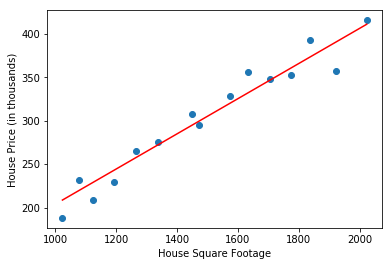

In [11]:
# plot the resulting model params
plt.scatter(footage, prices)
plt.xlabel('House Square Footage')
plt.ylabel('House Price (in thousands)')

# find the fit model's x, y values for the first, last observations in the dataset
x_vals = [ footage[0], footage[len(footage)-1] ]
y_vals = [ m * x_vals[0] + b, m * x_vals[1] + b ]

plt.plot(x_vals, y_vals, color='red')

Awesome! Using gradient descent, we optimized $m$ and $b$ to find model parameters that minimize our selected loss function, the Half-Mean Sum of Squared Error.

If we in fact visualized the model parameters after each iteration of gradient descent, we should find that the linear model slowly and continuously approaches its optimal resting place [[source](https://bl.ocks.org/duhaime/0805ea30469cb970e3202e400b60ad2a)]:

In [1]:
from IPython.display import IFrame

IFrame(src='https://s3.amazonaws.com/duhaime/blog/visualizations/linear-regression-gradient-descent.html', width=1000, height=640)

That's all there is to it! Using gradient descent as we have done above lets us efficiently optimize model parameters. While we've only used gradient descent to improve a linear model, however, researchers use exactly the same gradient descent algorithm (and slight variations thereof) to build neural network models. In fact, numerical optimization of the sort we've just discussed is ubiqutious in machine learning, so congratulations on getting this far!

# Conclusion

This has been a whirlwind tour through numerical optimization through one of the simplest of application cases, linear regression. As we've seen, linear regression models are tools that let us find a line of best fit within some continuous data. While we used the square footage of a house to predict the house price, there are lots of applications for linear models in machine learning.

More importantly, focusing on linear models let us consider the fundamental engine of modern machine learning, namely numerical optimization. We discussed the fact that one can use a loss function to measure the degree to which a linear regression model fits some data. We also discussed the fact that running a parameter sweep over each model parameter lets us visualize a full loss function that shows how the model fit improves or degrades as each variable changes. Finally, we discussed the fact that we want to find a minimum of this loss function in order to identify the parameters that give the model its best fit. To find the minimum of our loss function, we used gradient descent, a popular technique for finding the minimum of some function.

If you've been able to internalize the core concepts above&mdash;particularly the role of a loss function and the way gradient descent lets us find minimum of that loss function, a.k.a. optimal model parameters&mdash;pat yourself on the back, as you're well on your way to mastering machine learning! To continue on your machine learning journey, feel free to consult the sources below:

# Going Further

From what we've discussed above, you will be prepared to analyze backpropagation in the context of neural networks, which are functions just like our linear regression function above (except neural networks have more internal function parameters than slope and intercept). For a simple notebook that shows how to use backpropagation to find optimal model parameters for a simple binary classificaiton task, you could refer to [this gist](https://gist.github.com/duhaime/9854126f79e3f1bb986b1c4894a4892d).

If it seems like machine learning will be important in your work, you may want to check out some of the resources listed below (arranged roughly from least to most technical):

* [A Friendly Introduction to Machine Learning](https://www.youtube.com/watch?v=IpGxLWOIZy4)

In this 30 minute video, Luis Serrano (head of machine learning at Udacity) offers intuitive, user-friendly introductions to the mechanics that drive a number of machine learning models, including Naive Bayes, Decision Tree, Logistic Regression, Neural Network, and Support Vector Machine classifiers. This video is a great place to start for those looking for quick intuitions about the ways these algorithms work.

* [Hands-On Machine Learning with Scikit-Learn and TensorFlow (OREILLY)](http://shop.oreilly.com/product/0636920052289.do)

This OREILLY book offers a great high-level introduction to machine learning with Python. Aurélien Géron guides readers through ways one can use scikit-learn and other popular libraries to build machine learning models in Python. This is a great choice for those who just want to get work done, without necessarily unlocking the insights that would allow one to build models from scratch.

* [Machine Learning Cheatsheets](https://becominghuman.ai/cheat-sheets-for-ai-neural-networks-machine-learning-deep-learning-big-data-678c51b4b463)

This collection of "cheat sheets" gives concise overviews of the api's and models behind many of the most prominent packages and concepts in machine learning and its allied fields, including different neural network architectures, numerical optimization techniques, algorithms appropriate for different tasks, scikit-learn, pandas, scikit-learn, scipy, ggpot2, dplyr and tidyr, big O notation, and a number of other topics. Recently identified as the "most popular" article on machine learning in Medium.

* [Mining of Massive Datasets](http://www.mmds.org/)

This Stanford University course and digital publication offer introductions to a wide array of subtopics in machine learning. The authors focus on helping readers gain an intuitive understanding of how machine learning models work. One of the most lucid and concise treatments of machine learning available on the web.

* [Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)

This Stanford University course offers a spectacular introduction to Convolutional Neural Networks, the cornerstone of modern machine learning in the domain of computer vision. If your work involves images or video materials, and you'd like to apply machine learning techniques to your data, this course will help you get up and running with state-of-the-art techniques in convnets.

* [Machine Learning (Andrew Ng, Coursera)](https://www.coursera.org/learn/machine-learning)

Andrew Ng's Coursera course on machine learning will help you master many of the fundamentals involved in modern machine learning. Professor Ng will guide you through a great deal of the math involved in contemporary machine learning, starting with simple linear classifiers and building up into complex neural network architectures. This class is ideal for those who like to understand the math behind the models they use.